# Autoregressive Model (AR)

In this Notebook, we will focus on: 1) Partial autocorrection function; 2) AR completion from scratch.

Source: 1) https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/; 2) https://timeseriesreasoning.com/contents/partial-auto-correlation/

## Partial autocorrelation function

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps. We can define the PACF with lag 2 just described as

$\operatorname{PACF}\left(\boldsymbol{T}_{i}, \boldsymbol{k}=\mathbf{2}\right)=\frac{\operatorname{Cov}\left(T_{i}\left|T_{(i-1)}, T_{(i-2)}\right| T_{(i-1)}\right)}{\sigma_{T_{i} \mid T_{(i-1)}} \times \sigma_{T_{(i-2)} \mid T_{(i-1)}}}$

In [8]:
import pandas as pd
from sklearn import linear_model

#Read the data into a pandas DataFrame and convert it to stationarity
df = pd.read_csv('AAPL_Open.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])

df['Open_diff1'] = df['Open'].diff()
df['Open_diff2'] = df['Open'].diff().diff()

In [9]:
df

,Open,Open_diff1,Open_diff2
Date,,,
2020-12-28,133.990005,NaN,NaN
2020-12-29,138.050003,4.059998,NaN
2020-12-30,135.580002,-2.470001,-6.529999
2020-12-31,134.080002,-1.500000,0.970001
2021-01-04,133.520004,-0.559998,0.940002
...,...,...,...
2021-12-20,168.279999,-1.649994,7.700012
2021-12-21,171.559998,3.279999,4.929993
2021-12-22,173.039993,1.479995,-1.800004


In [11]:
#add two columns containing the LAG=1 and LAG=2 version of the data to the DataFrame
df['T_(i-1)'] = df['Open_diff1'].shift(1)
df['T_(i-2)'] = df['Open_diff1'].shift(2)

In [12]:
df

,Open,Open_diff1,Open_diff2,T_(i-1),T_(i-2)
Date,,,,,
2020-12-28,133.990005,NaN,NaN,NaN,NaN
2020-12-29,138.050003,4.059998,NaN,NaN,NaN
2020-12-30,135.580002,-2.470001,-6.529999,4.059998,NaN
2020-12-31,134.080002,-1.500000,0.970001,-2.470001,4.059998
2021-01-04,133.520004,-0.559998,0.940002,-1.500000,-2.470001
...,...,...,...,...,...
2021-12-20,168.279999,-1.649994,7.700012,-9.350006,4.169998
2021-12-21,171.559998,3.279999,4.929993,-1.649994,-9.350006
2021-12-22,173.039993,1.479995,-1.800004,3.279999,-1.649994


Bad pipe message: %s [b'\rz\xa9\xcdG\xdfr\xdb\x8ai{\x13\x82\x0e\xcc\xfc\xff\x89 n\xb2\xe8}a\xfbL\x01\x02\x12\xa3\xbc']
Bad pipe message: %s [b'\xc2\xb0\x9d\xef\xf9\x02\xd7\xbf\x97\xf4e"M\x9b\x97>1n\x00\x00\xf4\xc00\xc0,\xc0(\xc0$\xc0\x14\xc0\n\x00\xa5\x00\xa3\x00\xa1\x00\x9f\x00k\x00j\x00i\x00h\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00\xa7\x00m\x00:\x00\x89\xc02\xc0.\xc0*\xc0&\xc0\x0f\xc0\x05\x00\x9d\x00=\x005\x00\x84\xc0/\xc0+\xc0\'\xc0#\xc0\x13\xc0\t\x00\xa4\x00\xa2\x00\xa0\x00\x9e\x00g\x00@\x00?\x00>\x003\x002\x001\x000\x00\x9a\x00\x99\x00\x98\x00\x97\x00E\x00D\x00C\x00B\xc0\x18\x00\xa6\x00l\x004\x00\x9b\x00F\xc01\xc0-\xc0)\xc0%\xc0\x0e\xc0\x04\x00\x9c\x00<\x00/\x00\x96\x00A\x00\x07\xc0\x11\xc0\x07\xc0\x16\x00\x18\xc0\x0c\xc0\x02\x00\x05\x00\x04\xc0\x12\xc0\x08\x00']
Bad pipe message: %s [b"T\n\x98^sh \xc6\x8e\xf4)]\xa2\xab\xce\xea\xb4\xe1\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x0

In [90]:
#drop the top four rows as they contain NaNs after shifting
df = df.drop(df.index[[0, 1, 2, 3]])

In [91]:
#fit a linear regression model on T_i and T_i-1 and add it's predictions to the DataFrame as a new column
lm = linear_model.LinearRegression()
df_X = df[['T_(i-1)']] #Note the double brackets! [[]]
df_y = df['Open_diff'] #Note the single brackets! []
model = lm.fit(df_X,df_y)
df['Predicted_T_i|T_(i-1)'] = lm.predict(df_X)

In [92]:
#create the time series of residuals corresponding to the predictions of this model and add it to the DataFrame.
# This gives us the first one of the two time series we need for calculating the PACF for X at LAG=2
#Observed minus predicted
df['Residual_T_i|T_(i-1)'] = df['Open_diff'] - df['Predicted_T_i|T_(i-1)']

In [93]:
# #repeat the above procedure to calculate the second time series of residuals
lm = linear_model.LinearRegression()
df_X = df[['T_(i-1)']] #Note the double brackets! [[]]
df_y = df['T_(i-2)'] #Note the single brackets! []
model = lm.fit(df_X,df_y)
df['Predicted_T_(i-2)|T_(i-1)'] = lm.predict(df_X)
#Observed minus predicted
df['Residual_T_(i-2)|T_(i-1)'] = df['T_(i-2)'] - df['Predicted_T_(i-2)|T_(i-1)']

#Finally, apply the formula for Pearson's r to the two time series of residuals to get the value of the PACF at LAG=2
print(df.corr(method='pearson')['Residual_T_i|T_(i-1)']['Residual_T_(i-2)|T_(i-1)'])

-0.3658449131350762


In [94]:
#or cheat, we can use a Python library statsmodels to calculate PACF
from statsmodels.tsa.stattools import pacf
print(pacf(df['Open_diff'], nlags=2)[2])

-0.3674042024977176


In [96]:
# Question: Based on the above process, please complete the partial correlation for Apple 
# close stock prices with lag 2 from scratch and test its result by using statsmodels library.

import pandas as pd
from sklearn import linear_model

#Read the data into a pandas DataFrame and convert it to stationarity
df = pd.read_csv('AAPL_Close.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
df['Close_diff'] = df['Close'].diff().diff()
#add two columns containing the LAG=1 and LAG=2 version of the data to the DataFrame
df['T_(i-1)'] = df['Close_diff'].shift(1)
df['T_(i-2)'] = df['Close_diff'].shift(2)
#drop the top four rows as they contain NaNs after shifting
df = df.drop(df.index[[0, 1, 2, 3]])
#fit a linear regression model on T_i and T_i-1 and add it's predictions to the DataFrame as a new column
lm = linear_model.LinearRegression()
df_X = df[['T_(i-1)']] #Note the double brackets! [[]]
df_y = df['Close_diff'] #Note the single brackets! []
model = lm.fit(df_X,df_y)
df['Predicted_T_i|T_(i-1)'] = lm.predict(df_X)
#create the time series of residuals corresponding to the predictions of this model and add it to the DataFrame.
# This gives us the first one of the two time series we need for calculating the PACF for X at LAG=2
#Observed minus predicted
df['Residual_T_i|T_(i-1)'] = df['Close_diff'] - df['Predicted_T_i|T_(i-1)']
# #repeat the above procedure to calculate the second time series of residuals
lm = linear_model.LinearRegression()
df_X = df[['T_(i-1)']] #Note the double brackets! [[]]
df_y = df['T_(i-2)'] #Note the single brackets! []
model = lm.fit(df_X,df_y)
df['Predicted_T_(i-2)|T_(i-1)'] = lm.predict(df_X)
#Observed minus predicted
df['Residual_T_(i-2)|T_(i-1)'] = df['T_(i-2)'] - df['Predicted_T_(i-2)|T_(i-1)']

#Finally, apply the formula for Pearson's r to the two time series of residuals to get the value of the PACF at LAG=2
print(df.corr(method='pearson')['Residual_T_i|T_(i-1)']['Residual_T_(i-2)|T_(i-1)'])

from statsmodels.tsa.stattools import pacf
print(pacf(df['Close_diff'], nlags=2)[2])

-0.30820812156361355
-0.310007197592584


## AR completion from scratch.

In this part, we use AR model to predict Apple's stock price. Again, the data is from Apple.Inc (one year: from 28/Dec/2020 to 27/Dec/2021). In order to help you gain the insights of AR model, instead of using exsiting Python Statsmodels library (https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html), I tend to show an example to implement AR from scratch. Addtionally, you can use this Statsmodels library to test performance by yourself. 

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

In [108]:
df=pd.read_csv('AAPL_Open.csv', parse_dates=['Date'], index_col=['Date'], dayfirst=True)
df.columns=['Open']

In [109]:
df

,Open
Date,
2020-12-28,133.990005
2020-12-29,138.050003
2020-12-30,135.580002
2020-12-31,134.080002
2021-01-04,133.520004
...,...
2021-12-20,168.279999
2021-12-21,171.559998
2021-12-22,173.039993


### Equation for AR model : <br>
$Y_{t}=c+\sum_{i=1}^{p} \varphi_{i} Y_{t-i}+\varepsilon_{t}=c+\varphi_{1} Y_{t-1}+\varphi_{2} Y_{t-2}+\ldots \ldots \ldots \ldots \ldots+\varphi_{p} Y_{t-p}+\varepsilon_{t}$

In [110]:
def AR(p,df):
    df_temp = df

    #Lag feature generation: Generating the lagged p terms
    for i in range(1,p+1):
        df_temp['Shifted_values_%d' % i ] = df_temp['Open'].shift(i) 
    
    train_size = (int)(0.8 * df_temp.shape[0])

    #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

    df_train_2 = df_train.dropna()
    #X contains the lagged values ,hence we skip some rows
    X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)

    #Y contains the value,it is the first column
    y_train = df_train_2.iloc[:,0].values.reshape(-1,1)
    #Running linear regression to generate the coefficents of lagged terms
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    
    theta  = lr.coef_.T
    intercept = lr.intercept_
    df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
    # df_train_2[['Value','Predicted_Values']].plot()

    X_test = df_test.iloc[:,1:].values.reshape(-1,p)
    df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
    # df_test[['Value','Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(df_test['Open'], df_test['Predicted_Values']))

    print("The RMSE is :", RMSE,", Value of p : ",p)
    return [df_train_2,df_test,theta,intercept,RMSE]

/usr/local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


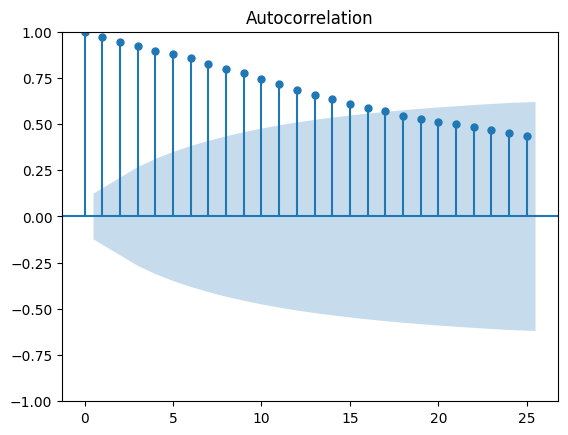

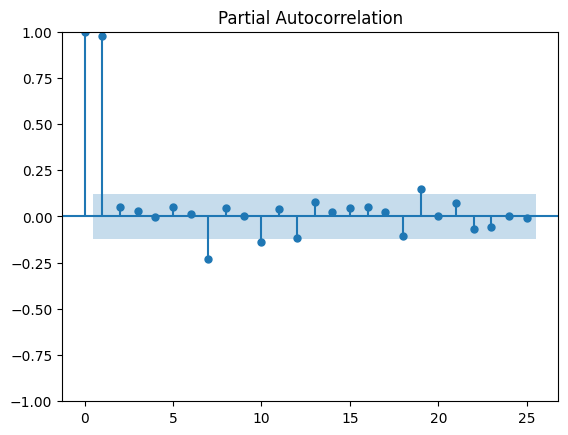

In [111]:
ACF = plot_acf(df.Open.dropna(),lags=25)
# with the PACF, we can figure out how many lags we need in the AR model.
PACF = plot_pacf(df.Open.dropna(),lags=25)

From the above figure of PACF, we can use 1 as the lag number.

In [112]:
lag_num = 1

#Step 2 : Fitting AR Model

We calculate the error on the test-set for each p, and pick the best one.

In [113]:
[df_train,df_test,theta,intercept,RMSE] = AR(lag_num,pd.DataFrame(df.Open))

The RMSE is : 3.2014571734295707 , Value of p :  1


<AxesSubplot: xlabel='Date'>

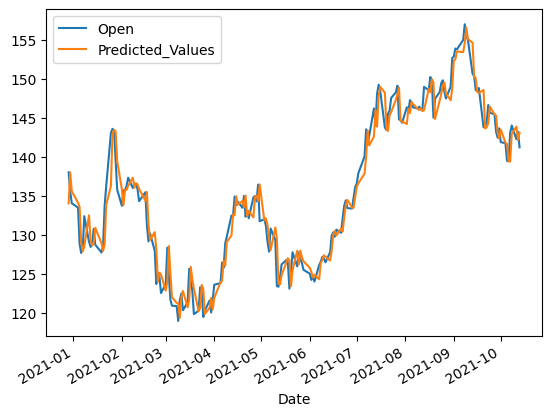

In [114]:
df_train[['Open','Predicted_Values']].plot()

<AxesSubplot: xlabel='Date'>

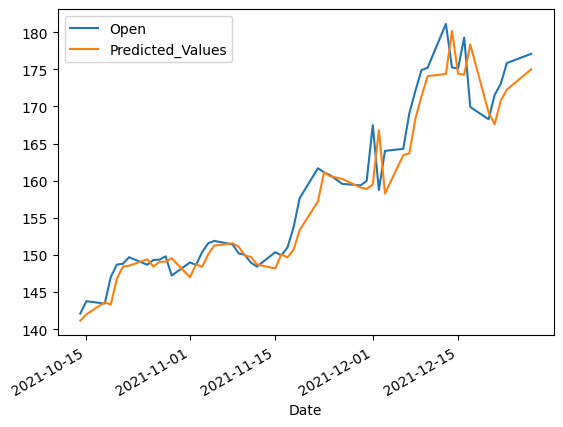

In [115]:
df_test[['Open','Predicted_Values']].plot()

/usr/local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


The RMSE is : 2.8836420929564492 , Value of p :  1


<AxesSubplot: xlabel='Date'>

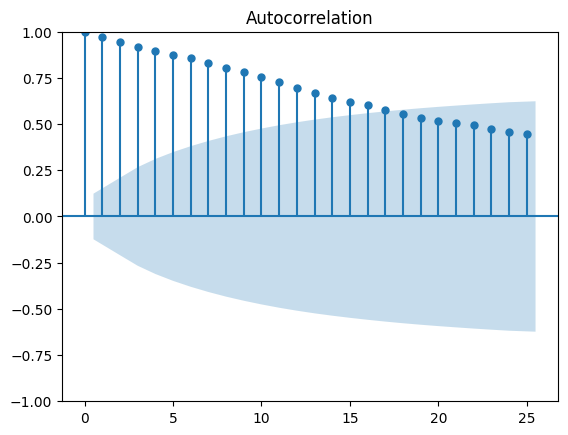

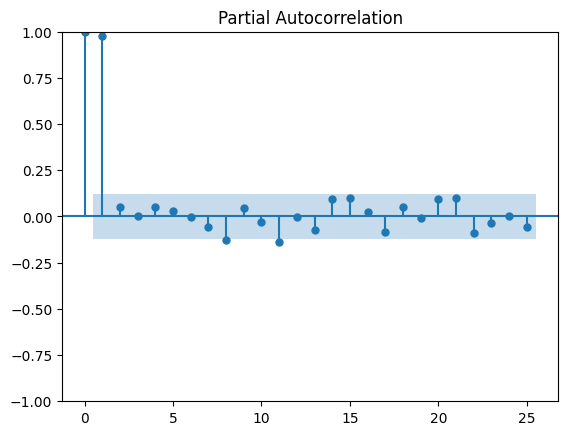

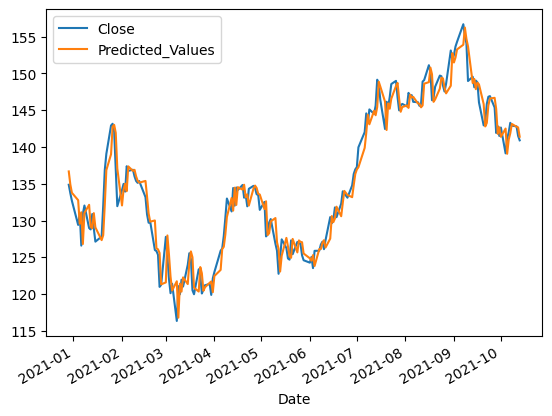

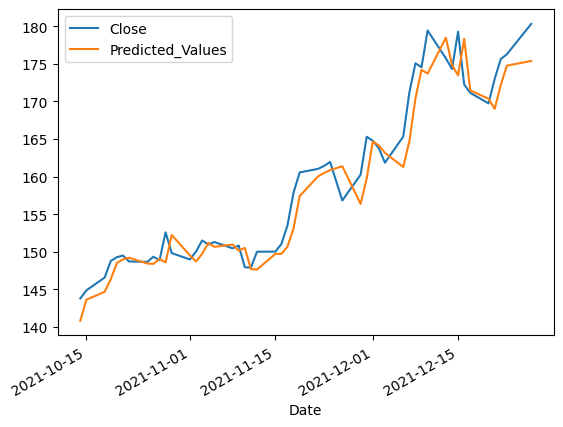

In [116]:
# Question: according to the above process, try to predict Apple close stock price with autoregressive. You can follow the above hyperp


df=pd.read_csv('AAPL_Close.csv', parse_dates=['Date'], index_col=['Date'], dayfirst=True)
df.columns=['Close']

def AR(p,df):
    df_temp = df

    #Lag feature generation: Generating the lagged p terms
    for i in range(1,p+1):
        df_temp['Shifted_values_%d' % i ] = df_temp['Close'].shift(i) 
    
    train_size = (int)(0.8 * df_temp.shape[0])

    #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

    df_train_2 = df_train.dropna()
    #X contains the lagged values ,hence we skip some rows
    X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)

    #Y contains the value,it is the first column
    y_train = df_train_2.iloc[:,0].values.reshape(-1,1)
    #Running linear regression to generate the coefficents of lagged terms
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    
    theta  = lr.coef_.T
    intercept = lr.intercept_
    df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
    # df_train_2[['Value','Predicted_Values']].plot()

    X_test = df_test.iloc[:,1:].values.reshape(-1,p)
    df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
    # df_test[['Value','Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(df_test['Close'], df_test['Predicted_Values']))

    print("The RMSE is :", RMSE,", Value of p : ",p)
    return [df_train_2,df_test,theta,intercept,RMSE]

ACF = plot_acf(df.Close.dropna(),lags=25)
# with the PACF, we can figure out how many lags we need in the AR model.
PACF = plot_pacf(df.Close.dropna(),lags=25)

lag_num = 1
[df_train,df_test,theta,intercept,RMSE] = AR(lag_num,pd.DataFrame(df.Close))
df_train[['Close','Predicted_Values']].plot()
df_test[['Close','Predicted_Values']].plot()